In [1]:
import scipy as sp
from scipy import io
import meshpy.triangle as triangle
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as pt
import math
import scipy.sparse
import scipy.sparse.linalg

In [2]:
def write_dat(mesh,facets,f):
    if type(f) is str:
            f = open(f, 'w')
    mesh_points = np.array(mesh.points)
    mesh_tris = np.array(mesh.elements)
    p_count = mesh_points.shape[0]
    t_count = mesh_tris.shape[0]
    f_count = len(facets)
    f.write(str(p_count))    
    f.write('\n') 
    for i in xrange(p_count):
        f.write(str(mesh_points[i][0]))
        f.write(' ')
        f.write(str(mesh_points[i][1]))
        f.write('\n') 
    f.write(str(t_count))
    f.write('\n')
    for i in xrange(t_count):
        f.write(str(mesh_tris[i][0]))
        f.write(' ')
        f.write(str(mesh_tris[i][1]))
        f.write(' ')
        f.write(str(mesh_tris[i][2]))
        f.write('\n')  
    f.write(str(f_count))
    f.write('\n')
    for i in xrange(f_count):
        f.write(str(facets[i][0]))
        f.write(' ')
        f.write(str(facets[i][1]))
        f.write('\n')  

In [3]:
def read_dat(f):
    if type(f) is str:
            f = open(f, 'r')
    points = []
    n_points = int(f.readline())
    #print f.readline()
    for i in xrange(n_points):
        pp = f.readline().split(' ')
        points.append([float(pp[0]),float(pp[1])])
    n_tris = int(f.readline())
    tris = []
    for i in xrange(n_tris):
        tt = f.readline().split(' ')
        tris.append([int(tt[0]),int(tt[1]),int(tt[2])])
    facets = []
    n_facets = int(f.readline())
    for i in xrange(n_facets):
        ff = f.readline().split(' ')
        facets.append((int(ff[0]),int(ff[1])))
        
    return np.array(points), np.array(tris),np.array(facets)

In [4]:
def stiff_matr_3d(triag, points):
    r1 = points[triag[0]]
    r2 = points[triag[1]]
    r3 = points[triag[2]]
    S_T = 0.5 * ((r2[0] - r1[0]) * (r3[1] - r1[1]) - (r2[1] - r1[1]) * (r3[0] - r1[0]))
    
    G = np.ones((3, 3))
    G[1:, 0] = r1
    G[1:, 1] = r2
    G[1:, 2] = r3
    G = np.linalg.solve(G, np.array([[0, 0], [1, 0], [0, 1]]))
    
    M = G.dot(G.T) * S_T/2
    
    return M

In [5]:
def right_hand_side((x,y)):
    return 1

In [6]:
def fem_solve(mesh_points, mesh_tris, mesh_facets, f):
    b = np.zeros(mesh_points.shape[0])

    A = sp.sparse.lil_matrix((mesh_points.shape[0], mesh_points.shape[0]))
    for triag in mesh_tris:
        M = stiff_matr_3d(triag, mesh_points)
        for k in xrange(3):
            for l in xrange(3):
                A[triag[k], triag[l]] += M[k, l]


    for triag in mesh_tris:
        r1 = mesh_points[triag[0]]
        r2 = mesh_points[triag[1]]
        r3 = mesh_points[triag[2]]
        S_T = 0.5 * ((r2[0] - r1[0]) * (r3[1] - r1[1]) - (r2[1] - r1[1]) * (r3[0] - r1[0]))

        for k in xrange(3):
            b[triag[k]] += 1./3 * S_T*f(mesh_points[triag[k]])

    for i in mesh_facets[:, 0]:
        A[i, :] = 0
        A[:, i] = 0
        A[i, i] = 1.
        b[i] = 0
    
    A = sp.sparse.csc_matrix(A)
    sol = sp.sparse.linalg.spsolve(A, b)
        
    return sol



In [7]:
def simple_indicator(mp, triplet, f, eps):
    i = triplet
    mes_tr = abs(0.5*((mp[i[0]][0] - mp[i[2]][0])*(mp[i[1]][1]-mp[i[2]][1])-(mp[i[1]][0] 
                                                                              - mp[i[2]][0])*(mp[i[0]][1]-mp[i[2]][1])))
    norm = 1.0/3*(f(mp[i[0]]) + f(mp[i[1]]) + f(mp[i[2]]))*mes_tr
    if norm > eps:
        return 1
    else:
        return 0

In [8]:
def on_boundary(p):
    if p[0] == 0:
        return 1
    if p[1] == 0:
        return 1
    if (p[0] == 1 and p[1]<=0.5) or (p[1]==0.5 and p[0]>=0.5) or (p[0]==0.5 and p[1]>=0.5) or (p[1] == 1 and p[0]<=0.5):
        return 1
    return 0

In [9]:
def refine_mesh(mp, mt, mf):
    points = list(mp)
    new_facets = list(mf)
    for i in mt:
        if simple_indicator(mp, i, right_hand_side, eps=10**-3):
            new_p1 = [0.5*(mp[i[0]][0]+mp[i[1]][0]),0.5*(mp[i[0]][1]+mp[i[1]][1])]
            new_p2 = [0.5*(mp[i[0]][0]+mp[i[2]][0]),0.5*(mp[i[0]][1]+mp[i[2]][1])]
            new_p3 = [0.5*(mp[i[1]][0]+mp[i[2]][0]),0.5*(mp[i[1]][1]+mp[i[2]][1])]
            if new_p1 not in mp:
                points.append(np.array(new_p1))
                if on_boundary(new_p1):
                    new_facets = [ x for x in new_facets if not (x==[i[0],i[1]]).all()]
                    new_facets.append([i[0], len(points) - 1])
                    new_facets.append([len(points) - 1, i[1]])

            if new_p2 not in mp:
                points.append(np.array(new_p2))
                if on_boundary(new_p2):
                    new_facets = [ x for x in new_facets if not (x==[i[0],i[2]]).all()]
                    new_facets.append([i[0], len(points) - 1])
                    new_facets.append([len(points) - 1, i[2]])
            if new_p3 not in mp:
                points.append(np.array(new_p3))
                if on_boundary(new_p3):
                    new_facets = [ x for x in new_facets if not (x==[i[1],i[2]]).all()]
                    new_facets.append([i[1], len(points) - 1])
                    new_facets.append([len(points) - 1, i[2]])
    return points, new_facets

In [10]:
def compute_grad(i, points, sol):
    grad = np.zeros(2)
    grad[0] = (sol[i[2]]*(points[i[0]][1]-points[i[1]][1]) + sol[i[0]]*(points[i[1]][1]-points[i[2]][1])+
        sol[i[1]]*(points[i[2]][1]-points[i[0]][1]))/(points[i[2]][0]*(points[i[0]][1]-points[i[1]][1]) + 
                                                         points[i[0]][0]*(points[i[1]][1]-points[i[2]][1])+
                                                         points[i[1]][0]*(points[i[2]][1]-points[i[0]][1])+10**-8)
    grad[1] = (sol[i[2]]*(points[i[0]][0]-points[i[1]][0]) + sol[i[0]]*(points[i[1]][0]-points[i[2]][0])+
        sol[i[1]]*(points[i[2]][0]-points[i[0]][0]))/(points[i[2]][0]*(points[i[0]][1]-points[i[1]][1]) + 
                                                         points[i[0]][0]*(points[i[1]][1]-points[i[2]][1])+
                                                         points[i[1]][0]*(points[i[2]][1]-points[i[0]][1])+10**-8)
    return grad
    

In [11]:
def get_edges(mt, mp):
    A_connect1 = np.zeros((len(mp), len(mp)))
    for i in mt:
        A_connect1[i[0], i[1]] = 1
        A_connect1[i[0], i[2]] = 1
        A_connect1[i[1], i[2]] = 1
    A = A_connect1+A_connect1.T
    set_edges = []
    for i in xrange(A.shape[0]):
        for j in xrange(i, A.shape[0]):
            if A[i,j] >0:
                set_edges.append([i,j])
    return set_edges


In [12]:
def find_triangle_neighbours(edges, mt):
    triangle_neighbours = np.zeros((len(edges),2)) -1
    k = 0
    for i in edges:
        l = 0
        for j in mt:
            edge1 = [j[0], j[1]]
            edge2 = [j[0], j[2]]
            edge3 = [j[1], j[2]]
            if (set(i) == set(edge1)) or (set(i) == set(edge2)) or (set(i) == set(edge3)):
                if triangle_neighbours[k][0]>=0:
                    triangle_neighbours[k][1] = l
                else:
                    triangle_neighbours[k][0] = l
            l = l+1
        k = k+1  
    return triangle_neighbours

In [13]:
def triangle_mesure(mp, i):
    mes_tr = abs(0.5*((mp[i[0]][0] - mp[i[2]][0])*(mp[i[1]][1]-mp[i[2]][1])-(mp[i[1]][0] 
                                                                              - mp[i[2]][0])*(mp[i[0]][1]-mp[i[2]][1])))
    return mes_tr

In [14]:
def p_triangle(mp, i):
    p = (mp[i[0]][0]**2+mp[i[1]][0]**2 +mp[i[2]][0]**2+mp[i[0]][1]**2+mp[i[1]][1]**2
            + mp[i[2]][1]**2 - 1*(mp[i[0]][0]*mp[i[1]][0]+ mp[i[0]][0]*mp[i[2]][0]+mp[i[1]][0]*mp[i[2]][0]
            + mp[i[0]][1]*mp[i[1]][1]+ mp[i[0]][1]*mp[i[2]][1]+mp[i[1]][1]*mp[i[2]][1]))
    return p
        
    

In [15]:
def norm_f(mp, i, f):
    mes_tr = triangle_mesure(mp,i)
    norm = 1.0/3*(f(mp[i[0]]) + f(mp[i[1]]) + f(mp[i[2]]))*mes_tr
    return norm

In [16]:
def compute_indicator(neigh, edges, mp, mt, sol, right_hand_side):
    indicator = np.zeros(len(neigh))-1
    for i in xrange(len(indicator)):
        if not (neigh[i] == -1).any():
            e = mp[edges[i][1]] - mp[edges[i][0]]
            n = [-e[0], e[1]]
            indicator[i] = (np.dot((compute_grad(mt[int(neigh[i][0])], mp, sol) 
                          - compute_grad(mt[int(neigh[i][1])], mp, sol)), n)**2*la.norm(n)**-1*la.norm(e) 
                          + 0.5*(norm_f(mp, mt[int(neigh[i][0])], right_hand_side) 
                                 + norm_f(mp, mt[int(neigh[i][0])], right_hand_side)))
    return indicator

           

In [17]:
def if_contains(what, where):
    for i in where:
        if (what == i).all():
            return 1
    return 0

In [18]:
def refine_true_rule(mp, mt, right_hand_side, sol, part):
    edges = get_edges(mt,mp)
    neigh = find_triangle_neighbours(edges, mt)
    ind = compute_indicator(neigh, edges, mp, mt, sol, right_hand_side)
    sort_ind = np.sort(ind)
    number_of_new_points = math.trunc(len(mp)*part)
    points = list(mp)
    for i in sort_ind[-number_of_new_points:]:
        for j in xrange(len(ind)):
            if i == ind[j]:
                new_p = (mp[edges[j][0]]+mp[edges[j][1]])/2.0
                if not if_contains(new_p, points):
                    points.append(np.array(new_p))
    return points


## Initial mesh
Here we create a simple mesh on a domain.

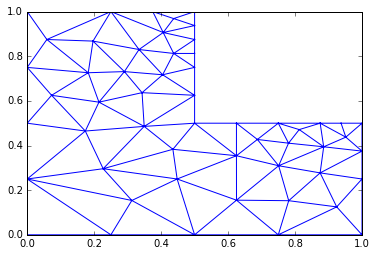

In [19]:
points = [ (0,0),(1,0),(1,0.5),(0.5,0.5),(0.5, 1), (0,1) ]

def round_trip_connect(start, end):
  result = []
  for i in range(start, end):
    result.append((i, i+1))
  result.append((end, start))
  return result

def needs_refinement(vertices, area ):
    vert_origin, vert_destination, vert_apex = vertices
    bary_x = (vert_origin.x + vert_destination.x + vert_apex.x) / 3
    bary_y = (vert_origin.y + vert_destination.y + vert_apex.y) / 3

    dist_center = math.sqrt( (bary_x-1)**2 + (bary_y-1)**2 )
    max_area = math.fabs( 0.05 * (dist_center-0.5) ) + 0.001
    return area > max_area

info = triangle.MeshInfo()
info.set_points(points)
info.set_facets(round_trip_connect(0, len(points)-1))

mesh = triangle.build(info, refinement_func=needs_refinement)
import matplotlib.pyplot as pt
mesh_points = np.array(mesh.points)
mesh_tris = np.array(mesh.elements)
mesh_facets = np.array(mesh.facets)
pt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
pt.show()
write_dat(mesh,mesh.facets,'ref_mesh.dat')



## Solve system 
We solve system on the mesh

In [27]:
mp, mt, mf = read_dat('ref_mesh.dat')

sol = fem_solve(mp, mt, mf, right_hand_side)

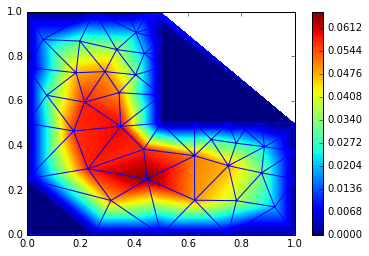

In [28]:
%matplotlib inline
import matplotlib.mlab as mlab
pt.triplot(mp[:, 0], mp[:, 1], mt)
xi = np.linspace(0, 1, 100) 
yi = np.linspace(0, 1, 100)
z = mlab.griddata(mp[:, 0], mp[:, 1], sol, xi, yi, interp='linear')
pt.contourf(xi, yi, z, 200)
pt.colorbar()

## A simple rule
Here the simplest rule of refinement presented. It is similar to uniform refinement

In [ ]:
N = 3

In [ ]:

for step in xrange(N):
    points, new_facets = refine_mesh(mp, mt, mf)
    info_s = triangle.MeshInfo()
    info_s.set_points(points)
    info_s.set_facets(new_facets)
    mesh = triangle.build(info_s)
    file_name  = 'ref_mesh'+str(step)+'.dat'
    write_dat(mesh,mesh.facets, file_name)
    mp, mt, mf = read_dat(file_name)
    

In [ ]:
mp, mt, mf = read_dat('ref_mesh2.dat')
sol = fem_solve(mp, mt, mf, right_hand_side)

In [ ]:
%matplotlib inline
import matplotlib.mlab as mlab
pt.triplot(mp[:, 0], mp[:, 1], mt)
xi = np.linspace(0, 1, 100) 
yi = np.linspace(0, 1, 100)
z = mlab.griddata(mp[:, 0], mp[:, 1], sol, xi, yi, interp='linear')
pt.contourf(xi, yi, z, 200)
pt.colorbar()

## Another more avanced method of refining mesh
part --- a part of points to add.

refine_true_rule --- function implements the rule with Indicator $I_t = (||f||_{t_1}+||f||_{t_2})/2 +[\nabla u])$

In [29]:
part = 0.5
N = 3

for step in xrange(N):
    points = refine_true_rule(mp, mt, right_hand_side, sol, part)
    info_s = triangle.MeshInfo()
    info_s.set_points(points)
    info_s.set_facets(mf)
    mesh = triangle.build(info_s)
    file_name  = 'ref_mesh_good'+str(step)+'.dat'
    write_dat(mesh,mesh.facets, file_name)
    mp, mt, mf = read_dat(file_name)
    sol = fem_solve(mp, mt, mf, right_hand_side)


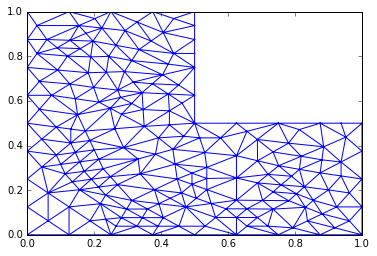

In [30]:
pt.triplot(mp[:, 0], mp[:, 1], mt)
pt.show()

In [36]:
mp, mt, mf = read_dat('ref_mesh_good2.dat')
sol = fem_solve(mp, mt, mf, right_hand_side)

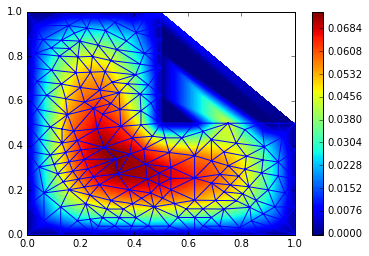

In [37]:
%matplotlib inline
import matplotlib.mlab as mlab
pt.triplot(mp[:, 0], mp[:, 1], mt)
xi = np.linspace(0, 1, 100) 
yi = np.linspace(0, 1, 100)
z = mlab.griddata(mp[:, 0], mp[:, 1], sol, xi, yi, interp='linear')
pt.contourf(xi, yi, z, 200)
pt.colorbar()